## Library imports

This section will contain the libraries for the development of the project.

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Initial data exploration

A first review of the dataset will be performed in order to know its general structure, distribution of values and main characteristics. In addition, the quality of the information will be evaluated by detecting missing values, inconsistent data types and possible duplicates.

In [22]:
df = pd.read_csv('cleaned.csv')  

print('\nBasic informations\n')
print(df.info())
print('\nSummary statistics\n')
print(df.describe())
print('\nMissing values\n')
print(df.isnull().sum())
print('\nDuplicated rows : ', df.duplicated().sum())
print()


Basic informations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                2952 non-null   object 
 1   Product_Description  2952 non-null   object 
 2   Screen_Size          2952 non-null   float64
 3   RAM                  2952 non-null   object 
 4   Processor            2952 non-null   object 
 5   GPU                  2604 non-null   object 
 6   GPU_Type             2718 non-null   object 
 7   Resolution           2565 non-null   object 
 8   Condition            2952 non-null   object 
 9   Price                2952 non-null   float64
dtypes: float64(2), object(8)
memory usage: 230.8+ KB
None

Summary statistics

       Screen_Size        Price
count  2952.000000  2952.000000
mean     14.550237   517.552805
std       1.175322   235.592872
min      10.000000     0.000000
25%      14.000000   325.990000


## Analyse the corresponding dataset

The Laptop_prices.csv dataset comprises 2,952 entries and 10 columns, detailing various specifications and prices of laptops. All rows are complete for the columns Brand, Product_Description, Screen_Size, RAM, Processor, Condition, and Price, while GPU, GPU_Type, and Resolution contain missing values in 348, 234, and 387 rows respectively. The dataset includes 8 categorical variables (object dtype) and 2 numerical ones (float64): Screen_Size and Price. On average, laptops have a screen size of approximately 14.55 inches, with a standard deviation of 1.18 inches. The average price is around $517.55, though values range from $0.00 to higher amounts, suggesting the presence of potential outliers or promotional items. No duplicate records were detected, and the overall data structure appears clean and ready for analysis after handling missing values in graphical specification fields.

### Categorical Variables Overview
To better understand categorical variables, we review the number of unique values and the most frequent categories:

In [23]:
cat_columns = ['Brand', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Resolution', 'Condition']

for col in cat_columns:
    if col in df.columns:
        print(f'\n{col} - Number of unique values: {df[col].nunique()}')
        print(df[col].value_counts().head())


Brand - Number of unique values: 25
Brand
Dell         1109
Lenovo        627
HP            578
Microsoft     197
Asus          134
Name: count, dtype: int64

RAM - Number of unique values: 23
RAM
16    1318
8     1185
32     273
4       84
64      47
Name: count, dtype: int64

Processor - Number of unique values: 48
Processor
Intel Core i5 11th Gen.    450
Intel Core i7 11th Gen.    330
Intel Core i7 12th Gen.    231
Intel Core i5 8th Gen.     223
Intel Core i5 10th Gen.    212
Name: count, dtype: int64

GPU - Number of unique values: 220
GPU
Intel Iris Xe Graphics          998
Intel UHD Graphics              468
Intel UHD Graphics 620          199
Intel HD Graphics                69
Intel(R) Iris(R) Xe Graphics     57
Name: count, dtype: int64

GPU_Type - Number of unique values: 8
GPU_Type
Integrated/On-Board Graphics      2265
Dedicated Graphics                 445
Integrated                           2
Iris Xe Graphics                     2
Intergrated Intel UHD Graphics       1


Then a preprocessing is performed on the Processor column of the data set, with the objective of decomposing the column information into three components:  Processor_Brand, Processor_Type and Processor_Gen. For this purpose, each string is segmented by space separation and extracts, respectively, the data.

In [24]:
def split_processor(proc):
    parts = proc.split()
    brand = parts[0] if len(parts) > 0 else None
    type_ = ' '.join(parts[1:3]) if len(parts) >= 3 else None
    gen = ' '.join(parts[3:5]) if len(parts) > 3 else None
    return pd.Series([brand, type_, gen])

df[['Processor_Brand', 'Processor_Type', 'Processor_Gen']] = df['Processor'].apply(split_processor)

print(f'\nNumber of unique values: {df[['Processor_Brand']].nunique()}\n')
print(df[['Processor_Brand']].value_counts().head())

print(f'\nNumber of unique values: {df[['Processor_Type']].nunique()}\n')
print(df[['Processor_Type']].value_counts())

print(f'\nNumber of unique values: {df[['Processor_Gen']].nunique()}\n')
print(df[['Processor_Gen']].value_counts())



Number of unique values: Processor_Brand    2
dtype: int64

Processor_Brand
Intel              2893
AMD                  59
Name: count, dtype: int64

Number of unique values: Processor_Type    8
dtype: int64

Processor_Type
Core i5           1386
Core i7           1201
Core i3            285
Ryzen 5             30
Core i9             21
Ryzen 7             15
Ryzen 3              7
Ryzen 9              7
Name: count, dtype: int64

Number of unique values: Processor_Gen    15
dtype: int64

Processor_Gen
11th Gen.        912
12th Gen.        474
8th Gen.         414
10th Gen.        403
13th Gen.        284
6th Gen.         140
7th Gen.          98
4th Gen.          93
9th Gen.          46
7000 Series       34
5th Gen.          29
5000 Series       13
3000 Series        6
4000 Series        3
6000 Series        3
Name: count, dtype: int64


Next, we'll do the same for the GPU column. This is more difficult, as there are several possible entries for the same output. In addition, wNext, we seek to structure and clean the information related to graphics cards (GPU) contained in a dataset, through a process of extraction, normalization and cross-validation with the processor brand. 

First, the GPU brand is identified from the first word of the string contained in the GPU column. Subsequently, a cleaning function is applied that corrects misspellings, removes special characters and standardizes the manufacturer's name using a mapping dictionary, grouping equivalent terms under the same name (e.g., “Radeon” and “AMD”).

GPU type is also homogenized by a feature that detects descriptions associated with integrated cards, and standardizes them under the unified “Integrated” category. This includes terms such as “Intel UHD”, “On-Board Graphics”, among others.

Finally, the GPU_Brand and GPU_Type columns are harmonized using a function that considers the processor brand in cases where an integrated GPU has been identified. This ensures consistency between the two variables.

Translated with DeepL.com (free version)e'll be looking for the processor brand for integrated GPUs, and have to deal with null values.

In [25]:
def get_gpu_brand(gpu):
    if pd.isna(gpu):
        return None
    return gpu.split()[0]

df['GPU_Brand'] = df['GPU'].apply(get_gpu_brand)
print(f'\nnumber of unique values before processing: {df[['GPU_Brand']].nunique()}\n')
def clean_gpu_brand(raw):
    if pd.isna(raw):
        return None
    first_word = raw.split()[0].lower().replace('(r)', '').replace('®', '').strip()

    mapping = {
        'intel': 'Intel',
        'nvidia': 'NVIDIA',
        'amd': 'AMD',
        'radeon': 'AMD',
        'iris': 'Intel',
        'microsoft': 'Microsoft',
        'integrated': 'Integrated',
        'skylake': 'Intel',
        'invidia': 'NVIDIA',
        'nvdia': 'NVIDIA',
        'i5-8250u': 'Intel'
    }

    return mapping.get(first_word, first_word.title())

df['GPU_Brand'] = df['GPU'].apply(clean_gpu_brand)

def normalize_gpu_type(gpu_type):
    if pd.isna(gpu_type):
        return gpu_type
    
    integrated_keywords = ['Integrated', 'On-Board Graphics', 'Iris', 'Intel UHD', 'Intergrated', 'Intel® UHD Graphics']
    for keyword in integrated_keywords:
        if keyword.lower() in gpu_type.lower():
            return 'Integrated'
    
    return gpu_type

df['GPU_Type'] = df['GPU_Type'].apply(normalize_gpu_type)

def process_gpu_info(row):
    gpu_brand = row['GPU_Brand']
    processor_brand = row['Processor_Brand']
    gpu_type = row['GPU_Type']

    if gpu_brand == 'Integrated':
        return pd.Series({
            'GPU_Brand': processor_brand,
            'GPU_Type': 'Integrated'
        })
    else:
        if gpu_type == 'Integrated':
            return pd.Series({
                'GPU_Brand': processor_brand,
                'GPU_Type': gpu_type 
            })
        else:
            return pd.Series({
                'GPU_Brand': gpu_brand,
                'GPU_Type': gpu_type 
            })

df[['GPU_Brand', 'GPU_Type']] = df.apply(process_gpu_info, axis=1)


print(f'\nNumber of unique values: {df[['GPU_Brand']].nunique()}')
print(f'\nMissing values {df['GPU_Brand'].isnull().sum()}')
print(df['GPU_Brand'].value_counts())

print(f'\nNumber of unique values: {df[['GPU_Type']].nunique()}')
print(f'\nMissing values {df['GPU_Type'].isnull().sum()}')
print(df['GPU_Type'].value_counts())




number of unique values before processing: GPU_Brand    23
dtype: int64


Number of unique values: GPU_Brand    3
dtype: int64

Missing values 106
GPU_Brand
Intel     2414
NVIDIA     347
AMD         85
Name: count, dtype: int64

Number of unique values: GPU_Type    2
dtype: int64

Missing values 234
GPU_Type
Integrated            2273
Dedicated Graphics     445
Name: count, dtype: int64


Then we normalize and categorize the screen resolutions present in a dataset, ensuring consistency in the format and reducing the cardinality of the variable to facilitate its analysis. 

First the values contained in the Resolution column are cleaned and validated. A regular expression is used to extract the numerical dimensions of the “width x height” format. If the values are outside a reasonable range (less than 100 or greater than 8000 pixels), or if the format does not fit the expected pattern, the label “Unknown” is assigned. 

Once normalized, the 10 most frequent resolutions in the dataset are identified. The Resolution column is then redefined using the top_resolution function, which retains the values belonging to the set of the most common resolutions and regroups all others under the “Other” category, while missing or empty values are classified as “Unknown”.

In [26]:
def normalize_resolution(res):
    if pd.isna(res):
        return 'Unknown'

    res = res.strip()

    match = re.match(r'(\d+)\s*x\s*(\d+)', res)
    if match:
        width = int(match.group(1))
        height = int(match.group(2))

        if width < 100 or height < 100 or width > 8000 or height > 8000:
            return 'Unknown'

        return f'{width} x {height}'
    
    return 'Unknown'

df['Resolution'] = df['Resolution'].apply(normalize_resolution)
top_10_resolutions = df['Resolution'].value_counts().nlargest(10).index

def top_resolution(res):
    if pd.isna(res) or res == '':
        return 'Unknown'
    
    if res in top_10_resolutions:
        return res
    
    return 'Other'

df['Resolution'] = df['Resolution'].apply(top_resolution)

print(f'\nNumber of unique values: {df[['Resolution']].nunique()}')
print(f'\nMissing values {df['Resolution'].isnull().sum()}')
print(df['Resolution'].value_counts())



Number of unique values: Resolution    11
dtype: int64

Missing values 0
Resolution
1920 x 1080    1706
Unknown         401
1920 x 1200     239
1366 x 768      174
Other           167
2560 x 1600      68
2256 x 1504      60
1536 x 1024      47
3840 x 2160      42
1920 x 1280      27
3840 x 2400      21
Name: count, dtype: int64


### Continuos Variables Overview

#### Price distribution

During the general exploration of the data set we found that there are unusual prices equal to 0, so we proceeded to explore visually and statistically how representative these values are.

Total entries: 2952
Prices = 0: 5 (0.17%)
Outliers based on IQR: 0 (0.00%)

Price summary statistics:
count    2952.000000
mean      517.552805
std       235.592872
min         0.000000
25%       325.990000
50%       489.990000
75%       699.000000
max       999.990000
Name: Price, dtype: float64


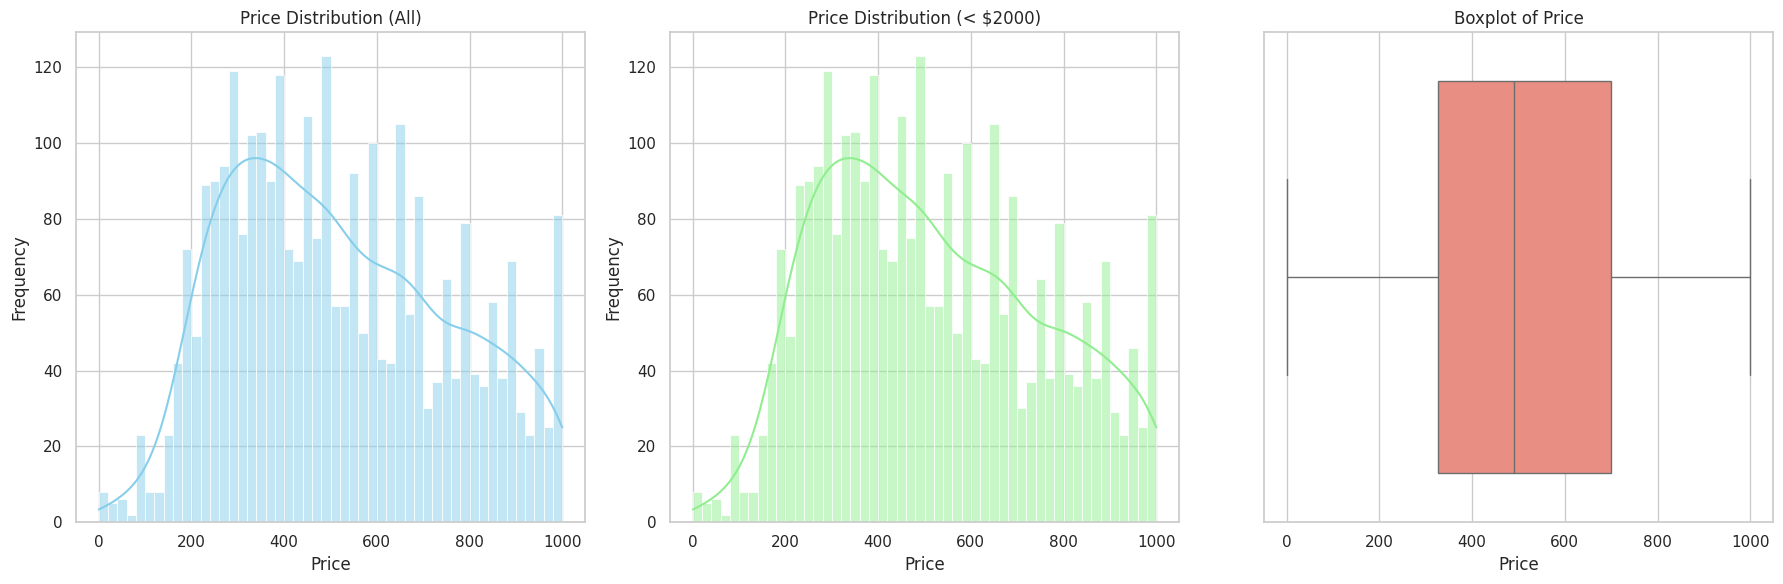

In [27]:
# Basic statistics
total_rows = len(df)
price_zero_count = (df["Price"] == 0).sum()
price_zero_pct = 100 * price_zero_count / total_rows

# IQR calculation for outlier detection
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outlier rows
outliers = df[(df["Price"] < lower_bound) | (df["Price"] > upper_bound)]
outlier_count = len(outliers)
outlier_pct = 100 * outlier_count / total_rows

# Print summary statistics and insights
print(f"Total entries: {total_rows}")
print(f"Prices = 0: {price_zero_count} ({price_zero_pct:.2f}%)")
print(f"Outliers based on IQR: {outlier_count} ({outlier_pct:.2f}%)")
print("\nPrice summary statistics:")
print(df["Price"].describe())

# Plot all visualizations in a single figure
plt.figure(figsize=(18, 6))
sns.set(style="whitegrid")

# Histogram of all prices
plt.subplot(1, 3, 1)
sns.histplot(df["Price"], bins=50, kde=True, color='skyblue')
plt.title("Price Distribution (All)")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Histogram for prices below $2000 (to remove skew from extremes)
plt.subplot(1, 3, 2)
filtered = df[df["Price"] < 2000]
sns.histplot(filtered["Price"], bins=50, kde=True, color='lightgreen')
plt.title("Price Distribution (< $2000)")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Boxplot of all prices to highlight outliers
plt.subplot(1, 3, 3)
sns.boxplot(x=df["Price"], color='salmon')
plt.title("Boxplot of Price")
plt.xlabel("Price")

# Final layout adjustment
plt.tight_layout()
plt.show()

The first histogram, representing the full price distribution, reveals a right-skewed pattern, which is common in pricing data. Most laptop prices are concentrated between approximately $300 and $600, indicating this is the core pricing range. However, the presence of a long right tail suggests a subset of laptops with significantly higher prices. Additionally, the density near zero may reflect abnormal entries, such as missing or placeholder values encoded as zero.

The second histogram filters out extreme values by limiting the display to prices under $2000. This allows a clearer view of the main distribution without the distortion caused by high-price outliers. Within this restricted range, the distribution remains asymmetrical but shows a smoother peak around the $400 mark, further confirming that the majority of laptops fall within a standard pricing window.

The boxplot summarizes the overall distribution and suggests the presence of potential practical outliers, particularly at the lower and upper extremes of the price range. However, based on the Interquartile Range (IQR) method, no statistical outliers were identified.